# Adaptive PDE discretizations on cartesian grids
## Volume : Algorithmic tools
## Part : Tensor decomposition techniques
## Chapter : Voronoi's reduction, in dimension 4 and 5


This notebook presents some tensor decomposition techniques that are at the foundation of our anisotropic PDE discretizations on cartesian grids. The general objective is to express a given symmetric positive definite (SPD) matrix $D$ under the form
$$
    D = \sum_{0 \leq i < I} \lambda_i e_i e_i^T,
$$
where $\lambda_i \geq 0$ is a non-negative weight, and $e_i \in Z^d$ is an integral offset.
This decomposition is a starting point for the design of various numerical schemes, for both first order and second order, linear and non-linear PDEs, which will be discussed in the subsequent notebooks.

The techniques used for constructing the above decomposition are non-trivial, related to classical yet subtle tools of discrete geometry. In this notebook, we however insist more on their properties 

This notebook is devoted to the decomposition of SPD tensors of size $d \times d$, where the dimension $d\in \{4,5\}$. A simpler set of techniques applies in dimension $d \in \{2,3\}$, see the notebook [I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)

**Acknowledgement.** 

The experiments presented in this notebook are part of ongoing research, with PhD student Guillaume Bonnet, in co-direction with [Frederic Bonnans](http://www.cmap.polytechnique.fr/~bonnans/).


**References.**

The tensor decomposition presented in this notebook is a central ingredient of the following paper:

Mirebeau, J.-M. (2017, April 12). Riemannian fast-marching on cartesian grids using Voronoi's first reduction of quadratic forms. HAL (Preprint).

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Computing the decomposition of a tensor](#1.-Computing-the-decomposition-of-a-tensor)
    * [1.1 Case of a  $4 \times 4$ tensor](#1.1-Case-of-a--$4-\times-4$-tensor)
    * [1.2 Case of a $5\times 5$ tensor](#1.2-Case-of-a-$5\times-5$-tensor)
    * [1.3 A field of tensors](#1.3-A-field-of-tensors)
  * [2. Under the hood: Voronoi's first reduction of tensors.](#2.-Under-the-hood:-Voronoi's-first-reduction-of-tensors.)
    * [2.1 Comparing the objective function](#2.1-Comparing-the-objective-function)
    * [2.2 Non-uniqueness of the maximizer](#2.2-Non-uniqueness-of-the-maximizer)
  * [3. Properties of Voronoi's reduction](#3.-Properties-of-Voronoi's-reduction)
    * [3.1 Smallness of the offsets](#3.1-Smallness-of-the-offsets)
    * [3.2 Stability](#3.2-Stability)
    * [3.3 Spanning, of the lattice $Z^d$ by the tensor decomposition offsets.](#3.3-Spanning,-of-the-lattice-$Z^d$-by-the-tensor-decomposition-offsets.)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('TensorVoronoi','Algo')

In [2]:
from agd import LinearParallel as lp
from agd.Selling import GatherByOffset
from agd.Plotting import savefig; #savefig.dirName = 'Figures/TensorVoronoi'

The routines for tensor decomposition are for efficiency purposes provided in a small c++ library, named FileVDQ where VDQ stands for "Voronoi Decomposition of Quadratic forms". This is in contrast with the two and three dimensional cases, where the decomposition algorithm is coded in Python (the c++ library can also be used in smaller dimensions). A function named `VoronoiDecomposition` provides the interface.

In [3]:
from agd.Eikonal import VoronoiDecomposition

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 0.1 Optional configuration

Uncomment the following line to use the GPU implementation of Voronoi's decomposition.

In [5]:
#VoronoiDecomposition.default_mode = 'gpu_transfer'

## 1. Computing the decomposition of a tensor

We illustrate our tensor decomposition method on random positive definite matrices, of the form 
$$
    D = A^T A,
$$
where $A$ is a square matrix with random coefficients w.r.t. the Gaussian normal law.

In [6]:
def MakeRandomTensor(dim,shape = tuple()):
    A = np.random.standard_normal( (dim,dim) + shape )
    return lp.dot_AA(lp.transpose(A),A)

In [7]:
# For reproducibility, we fix the random seed
np.random.seed(42) 

The inserse operation to tensor decomposition is, of course, reconstruction, defined by 
$$
    (\lambda_i, e_i)_{i=1}^I \mapsto D = \sum_{1 \leq i \leq I} \lambda_i e_i e_i^T
$$

In [8]:
def Reconstruct(coefs,offsets):
     return lp.mult(coefs,lp.outer_self(offsets)).sum(2)

In [9]:
def LInfNorm(a):
    return np.max(np.abs(a))

### 1.1 Case of a  $4 \times 4$ tensor

In [10]:
D4 = MakeRandomTensor(4)

In [11]:
coefs,offsets = VoronoiDecomposition(D4)

removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.580505 -0.731514 4.028950 -0.247864 2.589515 6.103511 0.659409 0.432862 3.384119 3.441647
Found a better neighbor ? 9 
obj 38.297738
state.objective 39.163462
bestObj 25.031653
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{0,0,0,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 3.146427 -0.955786 4.953431 -1.092271 -2.951257 3.441647 -2.341651 -3.513996 3.384119 6.103511
Found a better neighbor ? 44 
obj 32.059645
state.objective 25.031653
bestObj 15.413136
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 3.146427 -0.955786 4.953431 -1.098371 -1.046388 1.542879 3.297436 -1.439435 -1.425140 4.028950
Found a better neighbor ? 56 
obj 18.292005
state.objective 15.413136
bestObj 12.926576
In set neighbor 
{{1,0,0,0},{0,1,0,0},{0,0,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 1
state.m 3.146427 -0.955786 4.953431 -1.098371 -1.046388 1.542879 0.151009 -0.483649 -0.3267

Our decomposition, of a $4 \times 4$ SPD tensor, involves either $10$ or $12$ coefficients and offsets. 
If the tensor is randomly generated, then each possibility arises with positive probability, in approximately half the cases.

For uniformity of the data structures, we always return $12$ coefficients and offsets, but the last two are often zero.

In [12]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.00623787 1.73966329 0.302155   0.27498616 0.18106995 0.06642844
 0.00623787 1.38738859 0.93488664 0.16328382 0.00623787 0.15724673]
Offsets : 
 [[ 1  0  0  0  1  1  0  0  0  1  1  1]
 [ 0  1  1  0 -1 -1  1  0  1 -1 -1 -2]
 [ 1  0  1  1  0  1  1  1  2 -1  0 -1]
 [ 2  0  1  0  1  2  0  1  1  1  2  1]]


By design, the coefficients are non-negative, and the reconstruction is exact up to numerical precision.

In [13]:
print("Minimal coefficient : ", np.min(coefs))
print("Reconstruction error : ", LInfNorm(D4-Reconstruct(coefs,offsets)))
assert np.allclose(D4,Reconstruct(coefs,offsets))

Minimal coefficient :  0.00623787272536705
Reconstruction error :  1.3322676295501878e-15


Drawing another tensor at random, we observe only $10$ non-zero coefficients and offsets.

In [14]:
MakeRandomTensor(4), MakeRandomTensor(4); # Please do not comment

In [15]:
D4b= MakeRandomTensor(4)
coefs,offsets = VoronoiDecomposition(D4b)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

removed Greedy basis
In better neighbor
state.vertex 1
state.m 1.510191 -0.671411 3.612540 -0.334420 0.162235 2.501703 -1.008228 1.168993 2.481918 3.398170
Found a better neighbor ? 6 
obj 27.659839
state.objective 25.643382
bestObj 20.679546
In set neighbor 
{{-1,-1,-1,0},{1,0,0,0},{0,1,0,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 5.937243 -0.504360 1.510191 -3.103365 -0.671411 3.612540 -2.642683 -1.008228 1.168993 3.398170
Found a better neighbor ? 44 
obj 22.696003
state.objective 20.679546
bestObj 14.046563
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 5.937243 -0.504360 1.510191 -2.329518 -0.334420 2.501703 3.147043 -0.501962 -2.147498 2.891904
Found a better neighbor ? 8 
obj 15.050488
state.objective 14.046563
bestObj 13.051398
In set neighbor 
{{0,0,0,1},{-1,-1,-1,0},{1,0,0,-1},{0,1,0,0}}
In better neighbor
state.vertex 1
state.m 2.891904 -0.497583 3.612540 0.255140 -2.605782 2.535060 -0.501962 -0.671411 -0.0

In [16]:
assert np.allclose(D4b,Reconstruct(coefs,offsets))

### 1.2 Case of a $5\times 5$ tensor

In [17]:
D5 = MakeRandomTensor(5)

In [18]:
coefs,offsets = VoronoiDecomposition(D5)

removed Greedy basis
In better neighbor
state.vertex 2
state.m 12.543534 -0.442058 2.945533 -2.728652 -0.008036 3.343810 -1.581378 0.612724 0.675320 3.390015
Found a better neighbor ? 2 
obj 42.504384
state.objective 40.002397
bestObj 34.972342
In better neighbor
state.vertex 0
state.m 12.543534 -12.041062 14.675151 1.581378 -0.920692 3.390015 -0.944530 -0.681031 -1.273410 3.060095
Found a better neighbor ? 192 
obj 36.861402
state.objective 34.972342
bestObj 28.123527
In better neighbor
state.vertex 0
state.m 12.543534 -2.091804 2.443585 -3.231123 0.188527 3.043568 -9.949259 0.401745 1.624437 11.428077
Found a better neighbor ? 288 
obj 48.022045
state.objective 28.123527
bestObj 25.900969
In better neighbor
state.vertex 0
state.m 10.803512 -2.670881 2.951031 -2.138380 0.615072 3.903289 -7.780849 0.722151 0.021776 8.148202
Found a better neighbor ? 288 
obj 41.462668
state.objective 25.900969
bestObj 25.578589
In better neighbor
state.vertex 0
state.m 8.412780 -1.518064 3.043568 -0.44

Our decomposition of $5 \times 5$ SPD tensors always involves $15$ coefficients and offsets. (Some coefficients may vanish but, contrary to the four dimensional case, this occurs with probability zero.)

In [19]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [5.91306866 0.09283979 0.24029056 1.33730873 0.8835638  0.80238202
 0.54030804 0.34849989 0.28825227 0.37243394 0.5609605  0.9851582
 0.16119026 0.16216179 0.10087599]
Offsets : 
 [[ 1  1  1  0  1  1  0  1  1  0  2  1  2  0  1]
 [ 0 -1  0  0  1  0  0 -1  0  1  0 -1  0  1  1]
 [ 0 -1  0  1  0 -1  0  0 -1  0 -1  0 -1  0 -1]
 [ 0  0  1  0  0 -1  1  0  1 -1  0 -1 -1  0  0]
 [ 0 -1  0  1  1  0  0  0 -1  1  0  0  0  1  0]]


In [20]:
print("Minimal coefficient : ", np.min(coefs))
print("Reconstruction error : ", LInfNorm(D5-Reconstruct(coefs,offsets)))

Minimal coefficient :  0.0928397860290459
Reconstruction error :  5.329070518200751e-15


In [21]:
assert np.allclose(D5,Reconstruct(coefs,offsets),atol=1e-5) # atol is for float32

### 1.3 A field of tensors

When provided with a numerical array shaped as $(d,d,n)$, or $(d,d,n_1,\cdots,n_d)$, our tensor decomposition routine automatically threads over the inner dimensions $n$ or $n_1,\cdots, n_d$.

<!---
**TODO** Perform a reshape in VDEUtils python library, avoiding such restrictions, and simplifying the c++ code ?
In fact the present code makes sense, in case one wants to implement anisotropic diffusion directly in c++.

This facility is intended for use in adaptive finite difference PDE schemes.
Note, however, that the field of $d \times d$ tensors, may only have depth $1$ or $d$.
-->

In [22]:
D4_field = MakeRandomTensor(4,(10,))
# Alternatively
#D4_field = MakeRandomTensor(4,(2,2,2,2))
#D5_field = MakeRandomTensor(4,(2,2,2,2,2))

In [23]:
coefs,offsets = VoronoiDecomposition(D4_field)

removed Greedy basis
In better neighbor
state.vertex 0
state.m 15.928589 -1.235547 8.976082 3.572368 -4.413083 2.850357 4.201079 -4.023803 2.449745 3.029490
Found a better neighbor ? 56 
obj 62.316002
state.objective 54.268397
bestObj 41.192598
In set neighbor 
{{1,0,0,0},{0,1,0,0},{0,0,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 1
state.m 15.928589 -1.235547 8.976082 3.572368 -4.413083 2.850357 -11.727511 -2.788256 -1.122622 10.555921
Found a better neighbor ? 4 
obj 64.647619
state.objective 41.192598
bestObj 31.027663
In set neighbor 
{{-1,-1,-1,-1},{1,0,0,0},{0,1,0,0},{-1,-1,0,-1}}
In better neighbor
state.vertex 0
state.m 2.881648 -6.537900 15.928589 -0.539196 -1.235547 8.976082 1.994628 -2.965532 -4.952279 3.957966
Found a better neighbor ? 14 
obj 36.958727
state.objective 31.027663
bestObj 23.715159
In set neighbor 
{{1,0,0,0},{1,1,0,0},{0,0,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 1
state.m 2.881648 -3.656252 5.734438 -0.539196 -1.774743 8.976082 -0.887019 2.68534

{{-1,-1,-1,0},{1,0,0,0},{0,1,0,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 5.530286 -2.682527 2.340718 -2.519287 0.620213 2.940921 2.958764 -2.197911 -2.557006 6.664436
Found a better neighbor ? 31 
obj 20.675508
state.objective 16.279686
bestObj 14.087456
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{-1,-1,-1,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 2.505950 -1.557265 4.041212 -1.367729 -0.404348 4.720854 1.899074 -2.320708 -1.515159 2.940921
Found a better neighbor ? -1 
obj 18.728872
state.objective 14.087456
bestObj 14.087456
removed Greedy basis
In better neighbor
state.vertex 1
state.m 0.967457 0.997218 1.567474 -0.657500 0.096631 3.166598 -1.192316 -1.801388 -0.732158 3.452249
Found a better neighbor ? 7 
obj 14.113160
state.objective 11.728528
bestObj 9.734093
In set neighbor 
{{1,0,0,0},{-1,1,0,0},{0,0,1,0},{1,0,0,1}}
In better neighbor
state.vertex 0
state.m 0.967457 0.029760 0.540497 -0.657500 0.754132 3.166598 -0.224858 -0.579312 -1.389658 2.035074
F

In [24]:
assert np.allclose(D4_field,Reconstruct(coefs,offsets))

## 2. Under the hood: Voronoi's first reduction of tensors.

The tensor decompositions computed in this notebook are the result of a linear program, which is well known in the field of lattice geometry (a subfield of discrete computational geometry).
The dual to this linear program is often referred to as Voronoi's first reduction. 

In detail, the decomposition of a tensor $D$ proceeeds by maximizing the sum of the weights
$$
    \text{maximize} \quad 
    \sum_{1 \leq i \leq I} \lambda_i,
$$
while the constraints enforce that the decomposition is valid
$$
    \text{subject to} \quad 
    \lambda_i \geq 0, \quad 
    e_i \in Z^d, \quad
    \text{and}  \quad
    \sum_{1 \leq i \leq I} \lambda_i e_i e_i^T = D.
$$
Note that the vectors $e_i \in Z^d$ are not fixed a-priori, and that $I$ is not bounded a-priori, hence that optimization problem is strictly speaking infinite dimensional.

Two motivations can be invoqued to justify the choice of objective function, which is the sum of the decomposition coefficients. Indeed, this approach:
* Promotes small offsets. This is clear in view of the trace identity
$$
    \mathrm{Tr}(D) = \sum_{1 \leq i \leq I} \lambda_i \|e_i\|^2,
$$
which relate the coefficients magnitudes with the offsets norms.
* Is highly symmetrical, allowing for efficient implementations. The numerical cost of our optimized implementation is expected to be low enough to compute one such decomposition for each point of the discretization grid of a PDE.

It can be shown that Voronoi's first reduction, the above linear program, has at least one solution for each positive definite symmetric matrix $D$. 
Interestingly however, the solution may not be unique, so that a selection principle becomes necessary. More precisely:
* In dimension $2$ and $3$, the linear program actually always has a unique solution, which can also be computed using Selling's algorithm, see the relevant notebook [I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/TensorSelling.ipynb).
* In dimension $4$, the linear program either has a unique solution, or a set of solutions that forms a triangle (equilateral) in the coefficients space. In the latter case, the triangle barycenter is returned.
* In dimension $5$, the linear program often has a $5$ dimensional set of solutions, forming a convex polyhedron. A vertex of this polyhedron is selected, in a consistent manner so as to ensure the continuity of the coefficients. 

### 2.1 Comparing the objective function

We empirically check, on a random example, that our tensor decomposition yields a large sum of coefficients.

For that purpose, we generate a matrix $D = \sum_{i=1}^I \lambda_i e_i e_i^T$ by drawing randomly the weights 
$(\lambda_i)$ and offsets $e_i$.

In [25]:
coefs = np.random.standard_normal(15)**2
offsets = np.random.uniform(-5,5,(5,15)).astype(int)

In [26]:
D5b = Reconstruct(coefs,offsets)

In [27]:
print("Sum of coefficients : ", np.sum(coefs))
print("Coefficients : ", coefs)
print("Offsets ; \n", offsets)

Sum of coefficients :  26.029629166601506
Coefficients :  [1.64010186e-01 1.58982835e+00 8.42470554e-01 4.50354692e+00
 1.06598451e+00 2.30848509e+00 2.34482637e-01 1.60506386e+00
 5.00796073e-01 1.96975685e-01 6.00057917e-01 8.59200099e-01
 3.54326801e-03 1.05058140e+01 1.04937004e+00]
Offsets ; 
 [[-3  0 -1  1  1 -4 -1  1  0  3  1 -3 -4  1 -4]
 [ 0  4  0 -1  1  0  0  4 -1  4  4 -3 -4 -3 -4]
 [-4  1 -4 -1  3 -4  3 -2 -3  1  1  3  2  3 -2]
 [-3  2  3  4  0 -1  2 -1  4  3  0  2  2 -3  4]
 [ 0  3 -1  3 -1 -4  4 -4 -1  4  4  0  1  0 -2]]


Our tensor decomposition yields, as expected, a larger sum of coefficients.

In [28]:
coefs,offsets = VoronoiDecomposition(D5b)

removed Greedy basis
In better neighbor
state.vertex 2
state.m 84.121469 0.808605 189.072880 70.396837 -88.007687 189.058267 -27.595349 61.223566 -112.321630 216.904608
Found a better neighbor ? 12 
obj 1543.183407
state.objective 1631.839707
bestObj 1346.879052
In better neighbor
state.vertex 0
state.m 356.216775 -111.716818 84.121469 -184.084997 28.403954 283.530357 -427.218424 97.992186 179.994985 630.606134
Found a better neighbor ? 147 
obj 2201.315900
state.objective 1346.879052
bestObj 925.223055
In better neighbor
state.vertex 0
state.m 271.577139 -88.818915 216.904608 -158.404524 112.321630 189.058267 -83.312864 27.595349 70.396837 84.121469
Found a better neighbor ? 381 
obj 1091.848783
state.objective 925.223055
bestObj 823.026928
In better neighbor
state.vertex 0
state.m 271.577139 -88.818915 216.904608 -113.172615 -23.502715 143.826357 -188.264275 61.223566 100.256588 189.072880
Found a better neighbor ? -1 
obj 1199.555478
state.objective 823.026928
bestObj 823.026928


In [29]:
print("Sum of new coefficients", np.sum(coefs))
print("Coefficients : ", coefs)
print("Offsets ; \n", offsets.astype(int))

Sum of new coefficients 411.51346376975874
Coefficients :  [  0.45441405  42.80148792   3.89099871   2.63908912  10.11443835
  80.67126692   0.35419077  26.78412094  10.27693749   7.15102796
  17.48091081  23.91171188 100.25658831  61.22356591  23.50271461]
Offsets ; 
 [[ 1  1  0  1  1  0  1  0  1  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  1  1  0  0  0  0  1  1  0]
 [ 0  1  0  0  1  0  0 -1  0  1  1  0  0 -1  1]
 [ 0  0  0  0 -1  1  0  0  0  0 -1  1  0  1 -1]
 [ 1  1  1  1  1  1  0  0  0  0  0  0  0  0  0]]


In this second example, we expose the non-linearity of our tensor decomposition by comparing:
* The average of the decompositions of two tensors.
* The decomposition of the average tensor.

In [30]:
coefs0,_  = VoronoiDecomposition(D4)
coefs1,_  = VoronoiDecomposition(D4b)
coefs01,_ = VoronoiDecomposition(D4+D4b)
print("Sum of coefficients, average decomposition : ", 0.5*(np.sum(coefs0)+np.sum(coefs1)))
print("Sum of coefficients, decomposition of the average : ", 0.5*np.sum(coefs01))

removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.580505 -0.731514 4.028950 -0.247864 2.589515 6.103511 0.659409 0.432862 3.384119 3.441647
Found a better neighbor ? 9 
obj 38.297738
state.objective 39.163462
bestObj 25.031653
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{0,0,0,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 3.146427 -0.955786 4.953431 -1.092271 -2.951257 3.441647 -2.341651 -3.513996 3.384119 6.103511
Found a better neighbor ? 44 
obj 32.059645
state.objective 25.031653
bestObj 15.413136
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 3.146427 -0.955786 4.953431 -1.098371 -1.046388 1.542879 3.297436 -1.439435 -1.425140 4.028950
Found a better neighbor ? 56 
obj 18.292005
state.objective 15.413136
bestObj 12.926576
In set neighbor 
{{1,0,0,0},{0,1,0,0},{0,0,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 1
state.m 3.146427 -0.955786 4.953431 -1.098371 -1.046388 1.542879 0.151009 -0.483649 -0.3267

removed Greedy basis
In better neighbor
state.vertex 1
state.m 1.510191 -0.671411 3.612540 -0.334420 0.162235 2.501703 -1.008228 1.168993 2.481918 3.398170
Found a better neighbor ? 6 
obj 27.659839
state.objective 25.643382
bestObj 20.679546
In set neighbor 
{{-1,-1,-1,0},{1,0,0,0},{0,1,0,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 5.937243 -0.504360 1.510191 -3.103365 -0.671411 3.612540 -2.642683 -1.008228 1.168993 3.398170
Found a better neighbor ? 44 
obj 22.696003
state.objective 20.679546
bestObj 14.046563
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 5.937243 -0.504360 1.510191 -2.329518 -0.334420 2.501703 3.147043 -0.501962 -2.147498 2.891904
Found a better neighbor ? 8 
obj 15.050488
state.objective 14.046563
bestObj 13.051398
In set neighbor 
{{0,0,0,1},{-1,-1,-1,0},{1,0,0,-1},{0,1,0,0}}
In better neighbor
state.vertex 1
state.m 2.891904 -0.497583 3.612540 0.255140 -2.605782 2.535060 -0.501962 -0.671411 -0.0

removed Greedy basis
In better neighbor
state.vertex 1
state.m 2.090696 -1.402924 7.641490 -0.582284 2.751750 8.605214 -0.348820 1.601855 5.866037 6.839817
Found a better neighbor ? 6 
obj 66.823301
state.objective 66.125662
bestObj 54.393588
In set neighbor 
{{-1,-1,-1,0},{1,0,0,0},{0,1,0,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 19.870483 -0.105487 2.090696 -8.990316 -1.402924 7.641490 -7.119072 -0.348820 1.601855 6.839817
Found a better neighbor ? 21 
obj 55.091227
state.objective 54.393588
bestObj 37.855653
In set neighbor 
{{-1,-1,-1,0},{1,0,0,0},{0,1,0,0},{0,0,1,1}}
In better neighbor
state.vertex 0
state.m 8.605214 -10.774680 19.870483 -0.582284 -0.105487 2.090696 8.617787 -16.109388 -1.751744 17.685017
Found a better neighbor ? 37 
obj 70.074430
state.objective 37.855653
bestObj 32.819082
In set neighbor 
{{-2,-1,-1,0},{1,0,0,0},{1,1,0,0},{-1,0,1,1}}
In better neighbor
state.vertex 0
state.m 10.743204 -5.853464 8.605214 -4.069100 -2.169466 6.926337 5.658382 -0.569

### 2.2 Non-uniqueness of the maximizer

We illustrate a case where a tensor $D$ admits several optimal decompositions, all maximizing the coefficients sum.
The specific example chosen is also interesting from the point of view of the spanning property, discussed in the next section.

Note that the choice of theses offsets is very specific, coming from a fine theoretical description of Voronoi's first reduction, the associated *perfect forms*, and their minimal vectors.

In [31]:
coefs_NonUnique = np.array([1,1,1,1])
offsets_NonUnique = np.transpose(np.array([[0,0,1,0],[0,1,0,-1],[1,-1,0,0],[1,0,-1,1]]))

In [32]:
print("Sum of coefficients : ", np.sum(coefs_NonUnique))

Sum of coefficients :  4


In [33]:
D4_NonUnique = Reconstruct(coefs_NonUnique,offsets_NonUnique)

In [34]:
coefs,offsets = VoronoiDecomposition(D4_NonUnique)

removed Greedy basis
In better neighbor
state.vertex 0
state.m 2.000000 -1.000000 2.000000 -1.000000 0.000000 2.000000 1.000000 -1.000000 -1.000000 2.000000
Found a better neighbor ? -1 
obj 10.000000
state.objective 8.000000
bestObj 8.000000


The tensor decomposition returned by our software is different, but the coefficients sum is no smaller.

In [35]:
print("Sum of new coefficients : ", np.sum(coefs))
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Sum of new coefficients :  4.000000000000001
Coefficients :  [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
Offsets : 
 [[ 1  0  0  0  1  1  0  0  0  1  1  1]
 [ 0  1  0  0  0 -1  1  1  0  0 -1 -1]
 [ 0  0  1  0 -1  0  0 -1  1 -1  0 -1]
 [ 0  0  0  1  0  0 -1  0 -1  1  1  1]]


In [36]:
assert np.allclose(D4_NonUnique, Reconstruct(coefs,offsets) )

## 3. Properties of Voronoi's reduction

We discuss three properties of the implemented tensor decomposition
$$
    D \mapsto (\lambda_i, e_i)_{i=1}^I,
$$
which seems to be desirable from the implementation point of view. There properties are
* **Smallness** of the offsets $e_i \in Z^d$.
* **Stability** of the coefficients $\lambda_i \in R$
* **Spanning** of the full lattice $Z^d$, by the offsets $(e_i)_{i=1}^I$. (Not always satisfied if $d=5$.)

### 3.1 Smallness of the offsets

By design, by the choice of the objective function in the underlying linear program, Voronoi's first reduction promotes small offsets in the tensor decompositions produced.
It is also possible to bound the offsets norm in terms of the tensor condition number
$$
    \|e_i\| \leq C \mu(D)^{d-1}
$$
where $\mu(D) := \sqrt{\|D\| \|D^{-1}\|}$ and $C$ is an absolute constant. 


Note that this theoretical bound is not sharp in dimension $d=3$, in that case one can prove that $\|e_i\| \leq C \mu(D)$, and may not be sharp either in higher dimension.

In [37]:
mu=10

We generate a SPD tensor with condition number $\mu$, and compare $\max_{1 \leq i \leq d} \|e_i\|$ with $\mu$. Successively $d=4$ and then $d=5$.

In [38]:
v = np.random.standard_normal(4)
v=v/np.linalg.norm(v)
D4_cigar = (mu**2-1)*lp.outer_self(v) + np.eye(4)

In [39]:
coefs,offsets = VoronoiDecomposition(D4_cigar)

removed Greedy basis
In better neighbor
state.vertex 0
state.m 37.640696 -36.389441 37.139910 23.435682 -23.274977 15.989649 20.284617 -20.145520 12.974203 12.229745
Found a better neighbor ? 59 
obj 159.490932
state.objective 119.199892
bestObj 72.050335
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 37.640696 -36.389441 37.139910 -24.686936 22.524509 18.312781 17.356079 -16.243921 -11.573636 9.301207
Found a better neighbor ? 12 
obj 104.538177
state.objective 72.050335
bestObj 46.101929
In set neighbor 
{{0,0,0,1},{-1,-1,0,0},{1,0,0,-1},{1,1,1,0}}
In better neighbor
state.vertex 1
state.m 9.301207 -1.112158 2.001723 8.054872 -0.139097 12.229745 -10.461479 0.160704 -12.974203 15.989649
Found a better neighbor ? 0 
obj 67.024887
state.objective 46.101929
bestObj 29.992186
In set neighbor 
{{1,0,0,0},{0,1,0,0},{-1,0,1,0},{1,0,0,1}}
In better neighbor
state.vertex 0
state.m 9.301207 -1.112158 2.001723 -1.246336 0.973061 5.421210 -

In [40]:
print("mu : ",mu)
print("max offset norm : ",np.max(np.linalg.norm(offsets,axis=0)))
print("Offsets : \n", offsets.astype(int))

mu :  10
max offset norm :  6.708203932499369
Offsets : 
 [[ 1  3  1  2  3  2  4  1  2  1  0  0]
 [-1 -3 -1 -1 -2 -2 -4 -2 -2  0  0  0]
 [ 1  2  1  1  2  2  3  1  1  0  0  0]
 [ 0  2  1  1  1  1  2  1  1  0  0  0]]


In [41]:
v = np.random.standard_normal(5)
v=v/np.linalg.norm(v)
D5_cigar = (mu**2-1)*lp.outer_self(v) + np.eye(5)

In [42]:
coefs,offsets = VoronoiDecomposition(D5_cigar)

removed Greedy basis
In better neighbor
state.vertex 0
state.m 6.983881 0.075464 1.000952 17.888119 0.225590 54.474462 -15.152833 -0.191095 -45.297640 39.371143
Found a better neighbor ? 220 
obj 155.886139
state.objective 125.580473
bestObj 66.852645
In better neighbor
state.vertex 0
state.m 6.983881 8.168952 16.049358 -12.440103 -15.529386 26.871417 -8.093489 -15.933727 14.385113 16.819047
Found a better neighbor ? 318 
obj 83.039622
state.objective 66.852645
bestObj 43.304374
In better neighbor
state.vertex 0
state.m 6.983881 -7.059345 8.135760 -4.271151 5.299793 11.862003 -8.093489 7.208168 -1.548614 16.819047
Found a better neighbor ? 280 
obj 59.491351
state.objective 43.304374
bestObj 30.485574
In better neighbor
state.vertex 0
state.m 1.000952 0.075464 6.983881 -0.047774 -2.788194 9.398178 -0.960784 1.109608 -5.968588 7.615951
Found a better neighbor ? 53 
obj 32.407142
state.objective 30.485574
bestObj 26.633314
In better neighbor
state.vertex 0
state.m 1.000952 0.033362 2.169

In [43]:
print("mu : ",mu)
print("max offset norm : ",np.max(np.linalg.norm(offsets,axis=0)))
print("Offsets : \n", offsets.astype(int))

mu :  10
max offset norm :  6.855654600401044
Offsets : 
 [[ 1  1  2  0  1  1  0  1  1  1  2  0  0  1  1]
 [ 0  0  0  0  0  0  1  0  0  0  1  1  0  1  1]
 [ 4  2  5  1  3  3  0  3  2  2  5  1  1  2  3]
 [-3 -2 -4 -1 -3 -2  0 -2 -2 -1 -4 -1  0 -2 -2]
 [ 1  0  1  0  1  0  0  1  1  0  1  0  0  0  0]]


### 3.2 Stability

The implemented tensor decompositions are stable, in the sense that the weight associated with and offset depends continuously on the tensor decomposed.
Mathematically, for any $e \in Z^d / \{\pm 1\}$, the following mapping is locally Lipschitz 
$$
    D \mapsto \lambda^e(D),
$$
where $\lambda^e(D)$ is the coefficient of $e e^T$ in the decomposition of $D$.

This continuity is achieved thanks to an appropriate selection principle, in the cases where the linear program defining Voronoi's first reduction does not have unique maximizer. Note that the coefficient of an offset $e_i$ and of its opposite $-e_i$ are regarded as identical.

We check the coefficients continuity by interpolating between two randomly drawn tensors.

In [44]:
def Interpolate(a,b,T=np.linspace(0,1,100)):
    return T, np.moveaxis(np.array([(1-t)*a + t*b for t in T]),0,-1)

In [45]:
T_interp, D4_interp = Interpolate(MakeRandomTensor(4),MakeRandomTensor(4))

In [46]:
coefs,offsets = VoronoiDecomposition(D4_interp)

removed Greedy basis
In better neighbor
state.vertex 1
state.m 3.380554 0.449804 1.222002 0.612870 0.419326 4.455093 -0.211848 1.938801 -2.348689 6.135556
Found a better neighbor ? 1 
obj 32.530633
state.objective 32.106936
bestObj 28.229334
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 3.380554 0.449804 1.222002 -4.443228 -2.091132 12.021648 0.211848 -1.938801 -0.621736 6.135556
Found a better neighbor ? 40 
obj 32.106936
state.objective 28.229334
bestObj 21.387732
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 3.380554 0.449804 1.222002 -2.767684 -0.030479 6.609907 2.718901 1.166603 -4.874046 5.537205
Found a better neighbor ? 63 
obj 19.054527
state.objective 21.387732
bestObj 19.054527
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 3.380554 0.449804 1.222002 -1.062674 -1.641328 6.515746 -2.718901 -1.166603 -0.98854

In set neighbor 
{{-1,-1,-1,-1},{1,0,0,0},{0,1,0,0},{0,-1,0,-1}}
In better neighbor
state.vertex 0
state.m 5.682009 -3.331771 3.380554 -1.585928 0.449804 1.222002 3.382060 -2.718901 -1.166603 5.537205
Found a better neighbor ? 31 
obj 20.374542
state.objective 14.936740
bestObj 14.199173
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{-1,-1,-1,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 2.399020 -1.184907 3.702948 -1.926054 -1.139590 5.879091 1.136124 -0.772198 -1.080725 1.222002
Found a better neighbor ? -1 
obj 15.743569
state.objective 14.199173
bestObj 14.199173
removed Greedy basis
In better neighbor
state.vertex 1
state.m 3.348656 0.444915 1.299452 0.610316 0.447344 4.434729 -0.208304 1.920959 -2.315269 6.081372
Found a better neighbor ? 1 
obj 32.544948
state.objective 32.128340
bestObj 28.286423
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 3.348656 0.444915 1.299452 -4.403887 -2.191711 12.087988 0.208304 -1.920959 

bestObj 19.487824
In set neighbor 
{{1,1,0,0},{-1,0,-1,0},{0,-1,0,0},{0,0,1,1}}
In better neighbor
state.vertex 1
state.m 5.573713 -1.083124 4.414366 -1.816929 0.475362 1.376902 0.964553 -1.657154 -1.001577 2.497800
Found a better neighbor ? 2 
obj 17.558719
state.objective 19.487824
bestObj 17.555342
In set neighbor 
{{-1,-1,-1,0},{1,0,0,0},{0,1,0,0},{0,0,1,1}}
In better neighbor
state.vertex 0
state.m 6.515599 -2.673660 5.573713 -3.806603 -1.083124 4.414366 1.658842 -0.852376 -1.181791 1.871548
Found a better neighbor ? 25 
obj 19.260093
state.objective 17.555342
bestObj 16.279379
In set neighbor 
{{1,1,1,1},{0,-1,-1,-2},{0,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.497800 -2.299846 7.171354 -1.657154 -0.967659 4.414366 1.496223 -1.708930 -1.181791 1.871548
Found a better neighbor ? 17 
obj 19.697238
state.objective 16.279379
bestObj 15.724563
In set neighbor 
{{-2,-1,-1,0},{1,0,0,0},{1,1,0,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 3.813606 -1.038601

state.vertex 0
state.m 3.189165 0.420472 1.686700 -4.207184 -2.694609 12.419686 0.190582 -1.831746 -0.507007 5.810457
Found a better neighbor ? 40 
obj 32.235362
state.objective 28.571870
bestObj 21.697468
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 3.189165 0.420472 1.686700 -2.591619 0.166964 6.326984 2.578111 0.565518 -4.716172 5.800721
Found a better neighbor ? 62 
obj 20.566431
state.objective 21.697468
bestObj 20.232504
In set neighbor 
{{1,1,0,0},{-1,0,-1,0},{0,-1,0,0},{0,0,1,1}}
In better neighbor
state.vertex 1
state.m 5.716810 -1.184982 4.332911 -2.107173 0.587436 1.686700 0.718974 -1.597304 -0.732482 2.695361
Found a better neighbor ? 9 
obj 18.794556
state.objective 20.232504
bestObj 18.794556
In set neighbor 
{{1,0,0,0},{0,1,0,0},{0,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 5.716810 -1.184982 4.332911 -2.107173 0.587436 1.686700 0.718974 -1.597304 -0.732482 2.695361
Found a better neighbor ? 22 


{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 1
state.m 3.093471 0.405806 1.919050 -2.909393 -1.653365 7.573202 -0.585755 -0.140830 -1.992818 4.010519
Found a better neighbor ? 7 
obj 20.611284
state.objective 19.439773
bestObj 18.628161
In set neighbor 
{{1,0,0,0},{-1,1,0,0},{0,0,1,0},{1,0,0,1}}
In better neighbor
state.vertex 0
state.m 3.093471 -2.687665 4.200908 -2.909393 1.256028 7.573202 2.507716 -2.242740 -4.902210 5.932479
Found a better neighbor ? 15 
obj 23.113641
state.objective 18.628161
bestObj 18.106468
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 3.093471 -2.687665 4.200908 -0.589885 -0.081606 4.271821 0.585755 -0.444925 -2.719404 4.010519
Found a better neighbor ? -1 
obj 18.996318
state.objective 18.106468
bestObj 18.106468
removed Greedy basis
In better neighbor
state.vertex 1
state.m 3.061573 0.400918 1.996499 0.587331 0.699509 4.251457 -0.176405 1.760377 -2.014493 5.593724
Found 

{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.997777 -0.391140 2.151399 -0.191083 -1.395853 4.851036 0.560456 -0.426707 -2.276493 4.187373
Found a better neighbor ? -1 
obj 19.866032
state.objective 19.012618
bestObj 19.012618
removed Greedy basis
In better neighbor
state.vertex 1
state.m 2.965879 0.386252 2.228848 0.579669 0.783564 4.190366 -0.165771 1.706849 -1.914234 5.431175
Found a better neighbor ? 1 
obj 32.716736
state.objective 32.385194
bestObj 28.971495
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.965879 0.386252 2.228848 -3.931799 -3.398664 12.884064 0.165771 -1.706849 -0.373156 5.431175
Found a better neighbor ? 40 
obj 32.385194
state.objective 28.971495
bestObj 22.058826
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.965879 0.386252 2.228848 -2.386210 0.397313 5.996907 2.413855 -0.135747 -4.531985 6.108157
Found 

In better neighbor
state.vertex 0
state.m 2.870184 0.371586 2.461197 -0.572007 -0.867620 4.129275 0.155138 -1.653322 -1.813975 5.268625
Found a better neighbor ? 3 
obj 23.694532
state.objective 20.387888
bestObj 19.644716
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 2.870184 -0.371586 2.461197 -2.298177 -0.496034 5.855445 -0.155138 -1.653322 -1.658837 5.268625
Found a better neighbor ? 3 
obj 19.954993
state.objective 19.644716
bestObj 19.525227
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.870184 -0.371586 2.461197 -0.200422 -1.593578 4.855234 0.526724 -0.807875 -1.873720 4.423178
Found a better neighbor ? -1 
obj 21.140978
state.objective 19.525227
bestObj 19.525227
removed Greedy basis
In better neighbor
state.vertex 1
state.m 2.838286 0.366697 2.538647 0.569453 0.895638 4.108912 -0.151594 1.635480 -1.780556 5.214442
Found a better neighbor ? 1 
obj 32.773999
state.ob

In better neighbor
state.vertex 1
state.m 2.742592 0.352031 2.770996 0.561792 0.979693 4.047821 -0.140961 1.581952 -1.680297 5.051893
Found a better neighbor ? 1 
obj 32.816946
state.objective 32.535025
bestObj 29.371120
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.742592 0.352031 2.770996 -3.656415 -4.102720 13.348441 0.140961 -1.581952 -0.239306 5.051893
Found a better neighbor ? 40 
obj 32.535025
state.objective 29.371120
bestObj 22.420183
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.742592 0.352031 2.770996 -2.180800 0.627662 5.666830 2.249600 -0.837013 -4.347799 6.415592
Found a better neighbor ? 57 
obj 24.094209
state.objective 22.420183
bestObj 20.323198
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.742592 0.352031 2.770996 -0.561792 -0.979693 4.047821 0.140961 -1.581952 -1.680297 5.051893
Found a be

Found a better neighbor ? 1 
obj 32.888525
state.objective 32.642047
bestObj 29.656567
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.583102 0.327588 3.158245 -3.459712 -4.605618 13.680140 0.123239 -1.492740 -0.143698 4.780977
Found a better neighbor ? 40 
obj 32.642047
state.objective 29.656567
bestObj 22.678296
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.583102 0.327588 3.158245 -2.034079 0.792197 5.431061 2.132275 -1.337916 -4.216237 6.635189
Found a better neighbor ? 57 
obj 25.354129
state.objective 22.678296
bestObj 20.242336
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.583102 0.327588 3.158245 -0.549022 -1.119785 3.946003 0.123239 -1.492740 -1.513199 4.780977
Found a better neighbor ? 3 
obj 23.227816
state.objective 20.242336
bestObj 19.587160
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1

state.objective 22.884786
bestObj 20.177646
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.455509 0.308033 3.468043 -0.538806 -1.231859 3.864549 0.109061 -1.421370 -1.379521 4.564244
Found a better neighbor ? 3 
obj 23.020387
state.objective 20.177646
bestObj 19.561579
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 2.455509 -0.308033 3.468043 -1.916703 -0.923825 5.242445 -0.109061 -1.421370 -1.270459 4.564244
Found a better neighbor ? -1 
obj 19.779702
state.objective 19.561579
bestObj 19.561579
removed Greedy basis
In better neighbor
state.vertex 1
state.m 2.423611 0.303145 3.545493 0.536253 1.259877 3.844185 -0.105517 1.403528 -1.346101 4.510061
Found a better neighbor ? 1 
obj 32.960103
state.objective 32.749069
bestObj 29.942013
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.423611 0.303145 3.545493 -3.263008 -5.

state.objective 30.090786
bestObj 23.630495
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.296019 0.283590 3.855292 -2.053572 -2.766932 6.685247 2.204679 1.615748 -4.506814 6.406668
Found a better neighbor ? 59 
obj 20.398998
state.objective 23.630495
bestObj 20.096784
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.296019 0.283590 3.855292 -0.526037 -1.371950 3.762731 0.091339 -1.332158 -1.212423 4.293329
Found a better neighbor ? 3 
obj 22.761100
state.objective 20.096784
bestObj 19.529604
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 2.296019 -0.283590 3.855292 -1.769982 -1.088360 5.006676 -0.091339 -1.332158 -1.121083 4.293329
Found a better neighbor ? -1 
obj 19.712283
state.objective 19.529604
bestObj 19.529604
removed Greedy basis
In better neighbor
state.vertex 1
state.m 2.264121 0.278702 3.932741 0.523483 1

state.vertex 0
state.m 2.200324 0.268924 4.087641 -0.518375 -1.456006 3.701640 0.080706 -1.278631 -1.112164 4.130779
Found a better neighbor ? 3 
obj 22.605529
state.objective 20.048267
bestObj 19.510418
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 2.200324 -0.268924 4.087641 -1.681949 -1.187081 4.865214 -0.080706 -1.278631 -1.031458 4.130779
Found a better neighbor ? -1 
obj 19.671831
state.objective 19.510418
bestObj 19.510418
removed Greedy basis
In better neighbor
state.vertex 1
state.m 2.168426 0.264036 4.165091 0.515821 1.484024 3.681277 -0.077162 1.260788 -1.078744 4.076596
Found a better neighbor ? 8 
obj 33.074629
state.objective 32.920305
bestObj 29.952257
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.168426 0.264036 4.165091 -2.684248 -1.748060 6.881345 -0.186874 -5.425879 0.592153 10.763263
Found a better neighbor ? 40 
obj 40.804015
state.objective 29.952257


In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.168426 0.264036 4.165091 -0.515821 -1.484024 3.681277 0.077162 -1.260788 -1.078744 4.076596
Found a better neighbor ? 3 
obj 22.553671
state.objective 20.032094
bestObj 19.504023
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 2.168426 -0.264036 4.165091 -1.652605 -1.219988 4.818061 -0.077162 -1.260788 -1.001582 4.076596
Found a better neighbor ? -1 
obj 19.658347
state.objective 19.504023
bestObj 19.504023
removed Greedy basis
In better neighbor
state.vertex 1
state.m 2.136528 0.259147 4.242540 0.513267 1.512042 3.660913 -0.073618 1.242946 -1.045325 4.022413
Found a better neighbor ? 8 
obj 33.088944
state.objective 32.941709
bestObj 29.917625
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.136528 0.259147 4.242540 -2.649796 -1.771189 6.823976 -0.185529 -5.485486 0.652247

bestObj 23.181608
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.008936 0.239592 4.552339 -1.745477 -3.167816 6.365584 1.949496 1.411169 -3.769259 5.695736
Found a better neighbor ? 59 
obj 20.359271
state.objective 23.181608
bestObj 19.951232
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.008936 0.239592 4.552339 -0.503052 -1.624116 3.579459 0.059440 -1.171576 -0.911646 3.805680
Found a better neighbor ? 3 
obj 22.294385
state.objective 19.951232
bestObj 19.472047
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 2.008936 -0.239592 4.552339 -1.505884 -1.384523 4.582291 -0.059440 -1.171576 -0.852206 3.805680
Found a better neighbor ? -1 
obj 19.590928
state.objective 19.472047
bestObj 19.472047
removed Greedy basis
In better neighbor
state.vertex 1
state.m 1.977038 0.234704 4.629789 0.500498 1.652134 3.559095 -0.055896

Found a better neighbor ? -1 
obj 19.536992
state.objective 19.446467
bestObj 19.446467
removed Greedy basis
In better neighbor
state.vertex 1
state.m 1.849446 0.215149 4.939587 0.490282 1.764208 3.477641 -0.041718 1.082364 -0.744548 3.534765
Found a better neighbor ? 8 
obj 33.217786
state.objective 33.134349
bestObj 29.605934
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 1.849446 0.215149 4.939587 -2.339728 -1.979357 6.307650 -0.173431 -6.021951 1.193090 10.639080
Found a better neighbor ? 40 
obj 41.649837
state.objective 29.605934
bestObj 22.932226
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 1.849446 0.215149 4.939587 -1.574313 -3.390529 6.187993 1.807727 1.297513 -3.359507 5.300774
Found a better neighbor ? 59 
obj 20.337200
state.objective 22.932226
bestObj 19.870370
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
sta

state.objective 22.832474
bestObj 19.838025
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 1.785649 0.205372 5.094487 -0.485174 -1.820244 3.436914 0.034629 -1.046679 -0.677709 3.426398
Found a better neighbor ? 3 
obj 21.931384
state.objective 19.838025
bestObj 19.427282
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 1.785649 -0.205372 5.094487 -1.300475 -1.614872 4.252214 -0.034629 -1.046679 -0.643080 3.426398
Found a better neighbor ? -1 
obj 19.496540
state.objective 19.427282
bestObj 19.427282
removed Greedy basis
In better neighbor
state.vertex 1
state.m 1.753751 0.200483 5.171936 0.482620 1.848263 3.416550 -0.031085 1.028837 -0.644290 3.372215
Found a better neighbor ? 8 
obj 33.260733
state.objective 33.198563
bestObj 29.502037
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 1.753751 0.200483 5.171936 -2.236372 -2.

obj 33.360942
state.objective 33.348394
bestObj 29.259611
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 1.530465 0.166263 5.714084 -1.995207 -2.210654 5.733955 -0.159988 -6.618024 1.794027 10.514897
Found a better neighbor ? 40 
obj 42.495659
state.objective 29.259611
bestObj 22.433463
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{2,1,1,0},{-1,1,0,1}}
In better neighbor
state.vertex 0
state.m 1.530465 0.166263 5.714084 -1.231985 -3.835956 5.832811 1.524190 1.070203 -2.540002 4.510849
Found a better neighbor ? 59 
obj 20.293058
state.objective 22.433463
bestObj 19.708646
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 0
state.m 1.530465 0.166263 5.714084 -0.464743 -2.044391 3.274005 0.006274 -0.903940 -0.410353 2.992933
Found a better neighbor ? 3 
obj 21.516526
state.objective 19.708646
bestObj 19.376121
In set neighbor 
{{-1,0,0,0},{0,1,0,0},{1,0,1,0},{0,0,0,1}}
In better neighbor
state.v

bestObj 20.537205
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 7.720172 -3.451465 5.415403 -1.549581 0.462430 1.402872 0.840473 -2.499526 -0.007903 2.776200
Found a better neighbor ? 5 
obj 25.536257
state.objective 20.537205
bestObj 19.628150
In set neighbor 
{{1,0,1,0},{-1,-1,0,0},{0,0,-1,0},{0,1,0,1}}
In better neighbor
state.vertex 1
state.m 6.023883 -3.181556 6.232644 0.146708 -1.087150 1.402872 -2.156465 -0.304884 -0.454527 3.192551
Found a better neighbor ? 0 
obj 23.941080
state.objective 19.628150
bestObj 19.334734
In set neighbor 
{{1,0,0,0},{0,1,0,0},{-1,0,1,0},{1,0,0,1}}
In better neighbor
state.vertex 0
state.m 6.023883 -3.181556 6.232644 -5.877175 2.094406 7.133339 3.867418 -3.486441 -4.175237 4.903504
Found a better neighbor ? -1 
obj 26.307615
state.objective 19.334734
bestObj 19.334734
removed Greedy basis
In better neighbor
state.vertex 0
state.m 1.370974 0.141820 6.101333 0.451973 2.184483 3.172187 0.011448 0.

obj 20.939614
state.objective 26.467172
bestObj 20.366991
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 7.934818 -3.518464 5.369157 -1.328860 0.468373 1.211484 0.754685 -2.374945 -0.029169 2.451102
Found a better neighbor ? 5 
obj 25.116881
state.objective 20.366991
bestObj 19.488583
In set neighbor 
{{1,0,1,0},{-1,-1,0,0},{0,0,-1,0},{0,1,0,1}}
In better neighbor
state.vertex 1
state.m 6.488581 -3.555867 6.267048 0.117376 -0.860487 1.211484 -2.324575 -0.230433 -0.439204 3.070369
Found a better neighbor ? 0 
obj 24.137734
state.objective 19.488583
bestObj 19.253830
In set neighbor 
{{1,0,0,0},{0,1,0,0},{-1,0,1,0},{1,0,0,1}}
In better neighbor
state.vertex 0
state.m 6.488581 -3.555867 6.267048 -6.371205 2.695380 7.465312 4.164006 -3.786300 -4.485833 4.909800
Found a better neighbor ? -1 
obj 26.826431
state.objective 19.253830
bestObj 19.253830
removed Greedy basis
In better neighbor
state.vertex 0
state.m 1.179586 0.112488 6.56603

Found a better neighbor ? 5 
obj 24.767400
state.objective 20.225146
bestObj 19.372277
In set neighbor 
{{1,0,1,0},{-1,-1,0,0},{0,0,-1,0},{0,1,0,1}}
In better neighbor
state.vertex 1
state.m 6.875830 -3.867793 6.295717 0.092933 -0.671601 1.051993 -2.464667 -0.168391 -0.426434 2.968551
Found a better neighbor ? 0 
obj 24.301612
state.objective 19.372277
bestObj 19.186411
In set neighbor 
{{1,0,0,0},{0,1,0,0},{-1,0,1,0},{1,0,0,1}}
In better neighbor
state.vertex 0
state.m 6.875830 -3.867793 6.295717 -6.782896 3.196192 7.741957 4.411163 -4.036184 -4.744663 4.915046
Found a better neighbor ? 26 
obj 27.258778
state.objective 19.186411
bestObj 19.098311
In set neighbor 
{{1,1,1,1},{0,0,1,1},{0,-1,-1,-1},{0,0,0,-1}}
In better neighbor
state.vertex 1
state.m 2.180186 -0.044050 3.167676 -1.543883 -2.327684 7.783409 -0.545362 -0.170383 -3.865801 4.915046
Found a better neighbor ? -1 
obj 20.189034
state.objective 19.098311
bestObj 19.098311
removed Greedy basis
In better neighbor
state.vertex 0

{{-2,-1,-1,0},{1,0,0,0},{1,1,0,0},{-1,0,1,1}}
In better neighbor
state.vertex 0
state.m 4.615412 -1.799902 1.963453 -3.738331 1.398520 8.019215 1.492072 -1.623140 -5.667094 6.202070
Found a better neighbor ? -1 
obj 21.986685
state.objective 18.740406
bestObj 18.740406
removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.892503 0.068490 7.263078 0.413665 2.604759 2.866733 0.064613 0.547091 0.258039 1.909270
Found a better neighbor ? 58 
obj 32.553074
state.objective 33.647256
bestObj 26.387001
In set neighbor 
{{1,1,0,0},{0,0,-1,-1},{0,-1,0,0},{0,0,1,0}}
In better neighbor
state.vertex 1
state.m 8.292561 -3.630128 5.292082 -7.331568 3.151850 7.263078 3.018424 -3.124773 -2.604759 2.866733
Found a better neighbor ? 8 
obj 20.350153
state.objective 26.387001
bestObj 20.083301
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 8.292561 -3.630128 5.292082 -0.960993 0.478278 0.892503 0.611704 -2.167309 -0.064613 1.909270
Found a

state.vertex 0
state.m 4.454325 -1.715844 1.909270 -3.705022 1.362179 8.078166 1.509993 -1.620218 -5.731447 6.251460
Found a better neighbor ? -1 
obj 21.806175
state.objective 18.565738
bestObj 18.565738
removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.860605 0.063601 7.340528 0.411111 2.632777 2.846370 0.068158 0.529249 0.291459 1.855087
Found a better neighbor ? 58 
obj 32.603075
state.objective 33.661572
bestObj 26.378983
In set neighbor 
{{1,1,0,0},{0,0,-1,-1},{0,-1,0,0},{0,0,1,0}}
In better neighbor
state.vertex 1
state.m 8.328335 -3.641294 5.284374 -7.404129 3.162026 7.340528 3.043888 -3.137829 -2.632777 2.846370
Found a better neighbor ? 8 
obj 20.291207
state.objective 26.378983
bestObj 20.054932
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 8.328335 -3.641294 5.284374 -0.924206 0.479268 0.860605 0.597406 -2.146546 -0.068158 1.855087
Found a better neighbor ? 5 
obj 24.348023
state.objective 20.054932
bes

obj 21.625665
state.objective 18.391071
bestObj 18.391071
removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.828707 0.058713 7.417977 0.408557 2.660796 2.826006 0.071702 0.511406 0.324879 1.800904
Found a better neighbor ? 58 
obj 32.653075
state.objective 33.675888
bestObj 26.370966
In set neighbor 
{{1,1,0,0},{0,0,-1,-1},{0,-1,0,0},{0,0,1,0}}
In better neighbor
state.vertex 1
state.m 8.364110 -3.652461 5.276667 -7.476690 3.172202 7.417977 3.069352 -3.150885 -2.660796 2.826006
Found a better neighbor ? 8 
obj 20.232261
state.objective 26.370966
bestObj 20.026563
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 8.364110 -3.652461 5.276667 -0.887419 0.480259 0.828707 0.583108 -2.125782 -0.071702 1.800904
Found a better neighbor ? 5 
obj 24.278127
state.objective 20.026563
bestObj 19.209449
In set neighbor 
{{1,0,1,0},{-1,-1,0,0},{0,0,-1,0},{0,1,0,1}}
In better neighbor
state.vertex 1
state.m 7.417977 -4.304488 6.335855 

state.vertex 0
state.m 4.737646 -3.385567 8.507207 -0.312345 -4.595724 4.926589 2.684336 -3.171210 0.028318 2.744552
Found a better neighbor ? 47 
obj 25.301352
state.objective 18.958932
bestObj 18.105614
In set neighbor 
{{1,0,0,-1},{-1,-1,-1,-1},{0,0,0,1},{0,1,0,1}}
In better neighbor
state.vertex 1
state.m 2.113526 -1.438076 3.411609 -0.060216 -2.285995 2.744552 -0.274572 0.359300 -0.426659 4.909338
Found a better neighbor ? 1 
obj 18.654759
state.objective 18.105614
bestObj 17.387015
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,0,0,1}}
In better neighbor
state.vertex 0
state.m 2.113526 -1.438076 3.411609 -0.615235 0.312462 0.701114 0.274572 -0.359300 -0.341931 4.909338
Found a better neighbor ? 1 
obj 18.105614
state.objective 17.387015
bestObj 17.311237
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.113526 -1.438076 3.411609 -1.498292 1.125614 1.584171 1.163504 -3.052309 -1.192973 7.602347
Found a better neighbor ? 

state.m 4.802783 -4.162846 6.510361 -0.324910 -1.505569 2.507522 -0.239233 -0.054934 -0.214741 0.605420
Found a better neighbor ? -1 
obj 16.326174
state.objective 15.847708
bestObj 15.847708
removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.573522 0.019604 8.037575 0.388125 2.884943 2.663097 0.100057 0.368667 0.592235 1.367439
Found a better neighbor ? 9 
obj 33.053080
state.objective 33.790413
bestObj 25.898610
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{0,0,0,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 8.650304 -4.784110 4.930787 -0.468724 -0.223569 1.367439 -3.273068 0.221845 0.592235 2.663097
Found a better neighbor ? 0 
obj 25.454919
state.objective 25.898610
bestObj 19.352473
In set neighbor 
{{1,0,0,0},{0,1,0,0},{0,0,1,0},{0,0,0,1}}
In better neighbor
state.vertex 1
state.m 8.650304 -4.784110 4.930787 -0.468724 -0.223569 1.367439 -3.273068 0.221845 0.592235 2.663097
Found a better neighbor ? 6 
obj 25.898610
state.objective 19.352473
bestObj 18.168003
I

state.vertex 0
state.m 5.384114 -1.059485 2.602007 -1.092370 0.312030 1.461337 0.827534 -0.692494 -1.094199 1.204889
Found a better neighbor ? 26 
obj 15.436645
state.objective 14.051657
bestObj 13.716713
In set neighbor 
{{1,1,1,1},{0,0,1,1},{0,-1,-1,-1},{0,0,0,-1}}
In better neighbor
state.vertex 1
state.m 5.054379 -0.167472 0.477828 -0.994586 -0.097364 2.318907 -0.245731 -0.110690 -0.581804 1.204889
Found a better neighbor ? -1 
obj 14.208174
state.objective 13.716713
bestObj 13.716713
removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.445930 0.000049 8.347374 0.377910 2.997016 2.581643 0.114235 0.297297 0.725914 1.150706
Found a better neighbor ? 9 
obj 33.253082
state.objective 33.847676
bestObj 25.578753
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{0,0,0,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 8.793401 -4.972497 4.934984 -0.411531 -0.428617 1.150706 -3.374926 0.415373 0.725914 2.581643
Found a better neighbor ? 44 
obj 24.748006
state.objective 25.57875

Found a better neighbor ? 8 
obj 14.914510
state.objective 13.327127
bestObj 12.622218
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 4.917141 -3.612251 4.848277 -4.144735 3.259796 4.554156 4.405942 -3.893805 -4.554553 4.937083
Found a better neighbor ? 27 
obj 20.409827
state.objective 12.622218
bestObj 12.118467
In set neighbor 
{{1,1,1,1},{-1,0,0,1},{0,-1,-1,-1},{0,0,-1,-1}}
In better neighbor
state.vertex 1
state.m 2.177445 -0.671430 1.042340 -0.611348 0.160231 3.962392 -0.009331 -0.121323 -0.251875 0.382133
Found a better neighbor ? 8 
obj 12.137130
state.objective 12.118467
bestObj 11.798006
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,0,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 2.177445 -0.671430 1.042340 -1.566097 0.511199 4.917141 0.680761 -0.921016 -0.772406 1.181827
Found a better neighbor ? -1 
obj 13.640039
state.objective 11.798006
bestObj 11.798006
removed Greedy basis
In better neighbor
state.vertex 0

bestObj 25.178932
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{0,0,0,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 8.972273 -5.207980 4.940231 -0.340041 -0.684927 0.879790 -3.502248 0.657283 0.893012 2.479825
Found a better neighbor ? 44 
obj 23.864366
state.objective 25.178932
bestObj 17.583651
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 8.972273 -5.207980 4.940231 -3.424252 0.952676 2.326399 8.710228 -5.597514 -2.904629 8.734622
Found a better neighbor ? 6 
obj 28.778678
state.objective 17.583651
bestObj 14.483061
In set neighbor 
{{1,0,1,0},{0,-1,0,-1},{0,0,-1,0},{0,1,0,0}}
In better neighbor
state.vertex 1
state.m 4.450167 -1.550295 2.479825 1.097853 -1.951954 2.326399 -4.255304 0.657283 -0.952676 4.940231
Found a better neighbor ? 0 
obj 22.993669
state.objective 14.483061
bestObj 12.287354
In set neighbor 
{{1,0,0,0},{0,1,0,0},{-1,0,1,0},{1,0,0,1}}
In better neighbor
state.vertex 0
state.m 4.450167 -1.550295 2.4798

In better neighbor
state.vertex 0
state.m 0.254541 -0.119040 0.809147 -0.025628 -0.233967 1.725709 0.227085 -0.126261 -0.564643 1.432206
Found a better neighbor ? 56 
obj 6.556648
state.objective 6.304126
bestObj 6.139292
In set neighbor 
{{1,0,0,0},{0,1,0,0},{0,0,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 1
state.m 0.254541 -0.119040 0.809147 -0.025628 -0.233967 1.725709 -0.027456 -0.007221 -0.539014 1.232576
Found a better neighbor ? -1 
obj 6.194203
state.objective 6.139292
bestObj 6.139292
removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.222643 -0.034172 8.889522 0.360032 3.193145 2.439098 0.139045 0.172400 0.959851 0.771424
Found a better neighbor ? 9 
obj 33.603086
state.objective 33.947886
bestObj 25.019004
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{0,0,0,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 9.043821 -5.302173 4.942330 -0.311445 -0.787451 0.771424 -3.553177 0.754047 0.959851 2.439098
Found a better neighbor ? 44 
obj 23.510910
state.object

obj 4.928848
state.objective 3.712601
bestObj 3.712601


In [47]:
print("Reconstruction error : ", LInfNorm(D4_interp - Reconstruct(coefs,offsets)))
assert np.allclose(D4_interp, Reconstruct(coefs,offsets),atol=1e-5)

Reconstruction error :  6.5503158452884236e-15


In [48]:
decomp = GatherByOffset(T_interp,coefs,offsets)

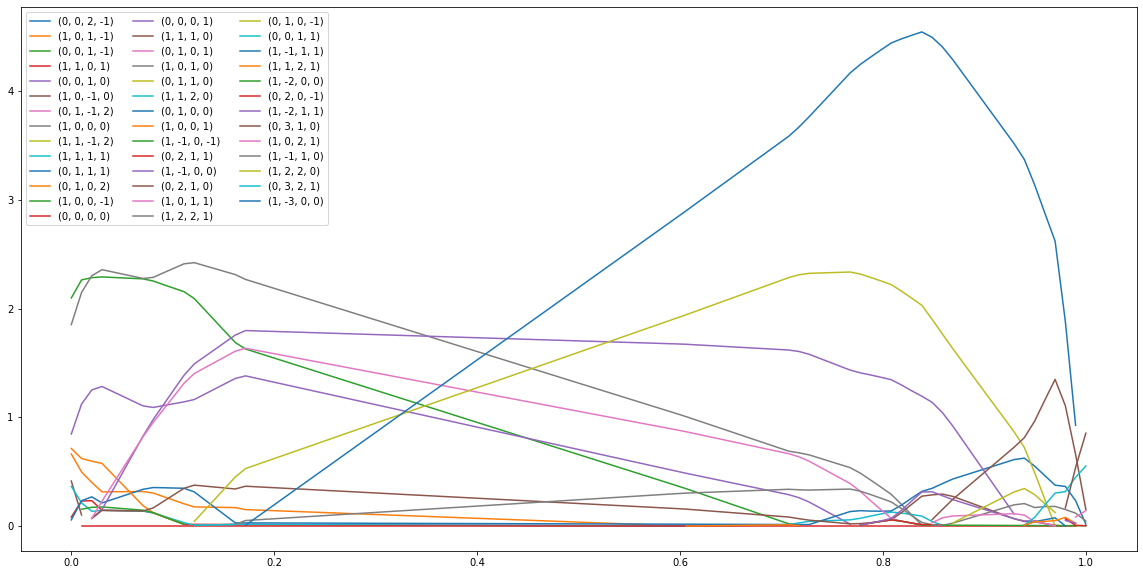

In [49]:
fig = plt.figure(figsize=(20,10))
for offset,(time,coef) in decomp.items():
    plt.plot(time,coef)
plt.legend(decomp.keys(),ncol=3)
savefig(fig,"Coefs_Vor4.pdf")

In [50]:
T_interp, D5_interp = Interpolate(MakeRandomTensor(5),MakeRandomTensor(5))
coefs,offsets = VoronoiDecomposition(D5_interp)
print("Reconstruction error : ", LInfNorm(D5_interp - Reconstruct(coefs,offsets)))
assert np.allclose(D5_interp, Reconstruct(coefs,offsets),atol=1e-5)

removed Greedy basis
In better neighbor
state.vertex 2
state.m 9.476982 5.568169 7.981928 3.780131 2.072864 5.148949 0.533775 -2.382984 -0.247388 2.308657
Found a better neighbor ? 13 
obj 61.125075
state.objective 69.373263
bestObj 60.127950
In better neighbor
state.vertex 0
state.m 15.056554 5.034394 9.476982 -9.726035 -8.943207 10.718090 -17.376806 -8.814525 13.753555 24.846007
Found a better neighbor ? 66 
obj 94.881562
state.objective 60.127950
bestObj 34.186846
In better neighbor
state.vertex 0
state.m 15.056554 -9.401181 10.974215 -4.691641 1.410232 2.308657 -10.689767 5.466449 2.747635 12.695211
Found a better neighbor ? 152 
obj 55.566380
state.objective 34.186846
bestObj 26.114114
In better neighbor
state.vertex 0
state.m 6.322573 -2.916759 2.308657 -3.169561 0.725364 4.112656 -2.413759 2.382984 -2.081885 7.981928
Found a better neighbor ? 345 
obj 30.941632
state.objective 26.114114
bestObj 23.293561
In better neighbor
state.vertex 0
state.m 4.096107 -0.961616 2.797711 -4.49

In better neighbor
state.vertex 0
state.m 6.335652 -0.293791 3.435061 -2.794041 -0.902480 6.987410 -4.985550 -1.438203 -1.206278 12.972573
Found a better neighbor ? 113 
obj 53.511481
state.objective 43.540381
bestObj 39.053982
In better neighbor
state.vertex 0
state.m 8.777499 -3.247819 6.335652 -2.238790 -0.293791 3.435061 -4.382212 -1.350101 1.731995 9.337124
Found a better neighbor ? -1 
obj 47.818407
state.objective 39.053982
bestObj 39.053982
removed Greedy basis
In better neighbor
state.vertex 2
state.m 6.265844 2.732393 6.965310 1.692344 2.084872 6.519810 0.288458 -0.869580 0.823875 3.460092
Found a better neighbor ? 7 
obj 60.692550
state.objective 62.243074
bestObj 56.589653
In better neighbor
state.vertex 0
state.m 6.265844 -5.977386 9.149019 -2.732393 3.601973 6.965310 1.403886 -4.040103 -2.954452 8.332152
Found a better neighbor ? 385 
obj 53.781881
state.objective 56.589653
bestObj 43.582321
In better neighbor
state.vertex 0
state.m 6.265844 -0.288458 3.460092 -2.732393 -

**CPU vs GPU implementation.** The CPU decomposition is stable w.r.t the inputs, locally Lipschitz more precisely. In contrast, the GPU implementation is discontinuous. This is due to a bit of code (selection of the decomposition in cases of non-uniqueness) which was not ported to the GPU, and could easily be fixed in the future.

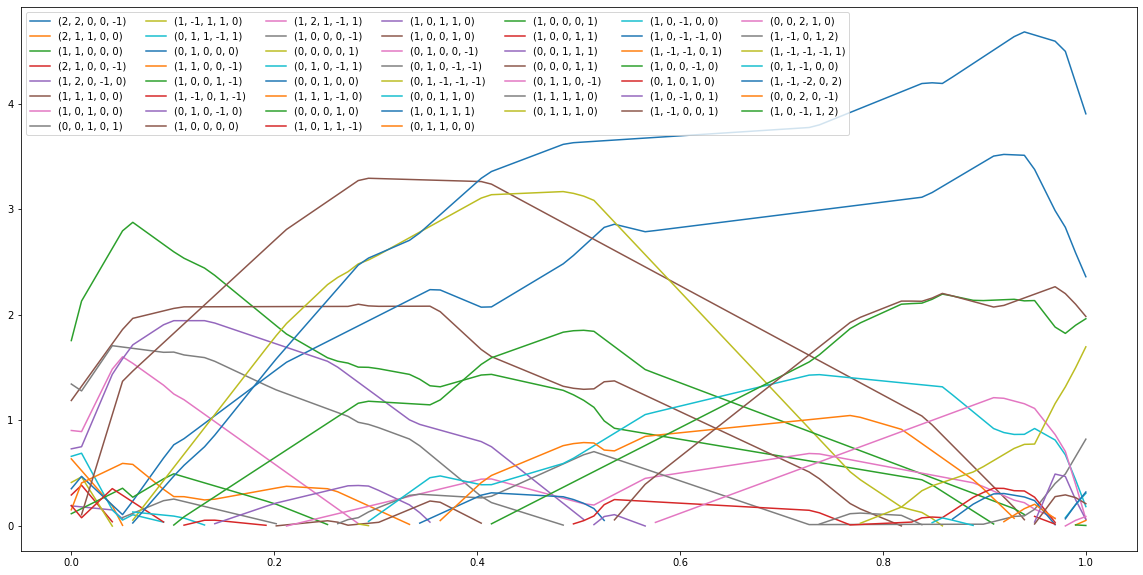

In [51]:
decomp = GatherByOffset(T_interp,coefs,offsets)
fig = plt.figure(figsize=(20,10))
for offset,(time,coef) in decomp.items():
    plt.plot(time,coef)
plt.legend(decomp.keys(),ncol=7);
savefig(fig,"Coefs_Vor5.pdf")

In [52]:
print("Matrix eigenvalues : ",np.linalg.eigvals(D5_interp[...,0]))
print("Coefficients : ", coefs[...,0])
print("Offsets : \n", offsets[...,0].astype(int))

Matrix eigenvalues :  [16.09060444  5.79356695  5.18317148  0.28922182  0.53419682]
Coefficients :  [0.20794792 0.63645127 1.75636743 0.29439048 0.19158944 1.18902423
 0.90525318 1.34492959 0.41295122 0.66033955 0.35351432 0.15422503
 0.11726199 0.19515092 0.7313639 ]
Offsets : 
 [[ 2  2  1  2  1  1  1  0  1  0  0  1  1  1  0]
 [ 2  1  1  1  2  1  0  0 -1  1  1  1  0 -1  1]
 [ 0  1  0  0  0  1  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0  1 -1  0  0  1  1 -1]
 [-1  0  0 -1  0  0  0  1  0  1  0 -1 -1 -1  0]]


In [53]:
print("Decomposed matrix : \n",D5_interp[...,0])

Decomposed matrix : 
 [[ 9.47698215e+00  5.56816864e+00  3.78013118e+00  5.33774689e-01
  -1.47131475e+00]
 [ 5.56816864e+00  7.98192782e+00  2.07286383e+00 -2.38298448e+00
  -9.02088673e-03]
 [ 3.78013118e+00  2.07286383e+00  5.14894904e+00 -2.47388327e-01
   2.00526914e+00]
 [ 5.33774689e-01 -2.38298448e+00 -2.47388327e-01  2.30865702e+00
  -9.72752458e-01]
 [-1.47131475e+00 -9.02088673e-03  2.00526914e+00 -9.72752458e-01
   2.97424548e+00]]


### 3.3 Spanning, of the lattice $Z^d$ by the tensor decomposition offsets. 

The tensor decompositions presented in this notebook are intended as the foundation to finite difference schemes. 
The offsets $(e_i)_{i=1}^I$ involved in the decomposition of a tensor $D = D(x)$ appearing in the discretized PDE, thus determine the local connectivity of the discretization grid around $x$.

In order to avoid chessboard artifacts, it is desirable that the offsets span the lattice $Z^d$ (using integer coefficients), which is referred to as the *spanning property*. Let us recall that a set of $d$ vectors $e_1,\cdots,e_d \in Z^d$ span the lattice $Z^d$ with integer coefficients iff
$$
    \det(e_1,\cdots,e_d)=1.
$$

*General findings* In dimension $d\leq 4$, the spanning property is guaranteed for the implemented tensor decomposition. In dimension $d=5$, it is not, but we provide a fix for it. However, it is not clear that this fix is desirable in practical implementations.

**Four dimensional decompositions span**

We can guarantee, by theoretical arguments, that our decompositions of $4\times 4$ SPD tensors obey the spanning property.

In [54]:
coefs,offsets = VoronoiDecomposition(D4)

removed Greedy basis
In better neighbor
state.vertex 0
state.m 0.580505 -0.731514 4.028950 -0.247864 2.589515 6.103511 0.659409 0.432862 3.384119 3.441647
Found a better neighbor ? 9 
obj 38.297738
state.objective 39.163462
bestObj 25.031653
In set neighbor 
{{1,1,0,0},{0,-1,1,0},{0,0,0,-1},{0,0,-1,0}}
In better neighbor
state.vertex 0
state.m 3.146427 -0.955786 4.953431 -1.092271 -2.951257 3.441647 -2.341651 -3.513996 3.384119 6.103511
Found a better neighbor ? 44 
obj 32.059645
state.objective 25.031653
bestObj 15.413136
In set neighbor 
{{-1,0,0,0},{0,-1,0,0},{1,1,1,0},{0,1,0,1}}
In better neighbor
state.vertex 0
state.m 3.146427 -0.955786 4.953431 -1.098371 -1.046388 1.542879 3.297436 -1.439435 -1.425140 4.028950
Found a better neighbor ? 56 
obj 18.292005
state.objective 15.413136
bestObj 12.926576
In set neighbor 
{{1,0,0,0},{0,1,0,0},{0,0,1,0},{-1,0,0,1}}
In better neighbor
state.vertex 1
state.m 3.146427 -0.955786 4.953431 -1.098371 -1.046388 1.542879 0.151009 -0.483649 -0.3267

In [55]:
np.linalg.det(offsets[:,0:4])

-1.0

**An intruiguing special case**

Interestingly, there are exists tensors $D\in S_4^{++}$ admitting an optimal decomposition, in the sense of Voronoi's first reduction see above, which is not spanning.

In [56]:
print("A tensors admitting a non-unique optimal decomposition : ", D4_NonUnique)
print("Coefficients of an optimal decomposition : ", coefs_NonUnique)
print("Offsets of an optimal decomposition : ", offsets_NonUnique)

A tensors admitting a non-unique optimal decomposition :  [[ 2 -1 -1  1]
 [-1  2  0 -1]
 [-1  0  2 -1]
 [ 1 -1 -1  2]]
Coefficients of an optimal decomposition :  [1 1 1 1]
Offsets of an optimal decomposition :  [[ 0  0  1  1]
 [ 0  1 -1  0]
 [ 1  0  0 -1]
 [ 0 -1  0  1]]


In [57]:
np.linalg.det(offsets_NonUnique)

-2.0

However, our tensor decomposition method selects a different decomposition, which is spanning.

In [58]:
coefs,offsets = VoronoiDecomposition(D4_NonUnique)

removed Greedy basis
In better neighbor
state.vertex 0
state.m 2.000000 -1.000000 2.000000 -1.000000 0.000000 2.000000 1.000000 -1.000000 -1.000000 2.000000
Found a better neighbor ? -1 
obj 10.000000
state.objective 8.000000
bestObj 8.000000


In [59]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
Offsets : 
 [[ 1  0  0  0  1  1  0  0  0  1  1  1]
 [ 0  1  0  0  0 -1  1  1  0  0 -1 -1]
 [ 0  0  1  0 -1  0  0 -1  1 -1  0 -1]
 [ 0  0  0  1  0  0 -1  0 -1  1  1  1]]


In [60]:
np.linalg.det(offsets[:,0:4])

1.0

**Five dimensional decompositions may not span**

We present below a tensor $D\in S_5^{++}$ whose Voronoi's decomposition is unique and non-spanning. Note that the choice of these offsets is very specific, coming from a fine theoretical description of Voronoi's first reduction, the associated *perfect forms*, and their minimal vectors.

In [61]:
coefs_NonSpanning = np.array([1,1,1,1,1])
offsets_NonSpanning = np.transpose(np.array(
    [[0,0,1,0,1],[0,0,1,1,0],[0,1,0,0,0],[1,0,0,0,0],[1,1,0,1,1]]))

In [62]:
D5_NonSpanning = Reconstruct(coefs_NonSpanning,offsets_NonSpanning)

In [63]:
print(np.linalg.det(offsets_NonSpanning))

-2.0


As can illustrated below, the explicit decomposition in terms of coefficients and offsets maximizes the sum of the weights (a property which defines Voronoi's reduction). In addition, and contrary to the previous four dimensional example, this maximizer is non-degenerate and attained for a unique decomposition - the one represented above which is reproduced by our decomposition algorithm.

In [64]:
coefs,offsets = VoronoiDecomposition(D5_NonSpanning)

removed Greedy basis
In better neighbor
state.vertex 2
state.m 2.000000 1.000000 2.000000 0.000000 0.000000 2.000000 1.000000 1.000000 1.000000 2.000000
Found a better neighbor ? -1 
obj 10.000000
state.objective 10.000000
bestObj 10.000000


In [65]:
print("Sum of coefficients : ", np.sum(coefs))
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Sum of coefficients :  5.0
Coefficients :  [1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
Offsets : 
 [[1 0 0 0 0 1 1 0 0 0 0 1 1 0 1]
 [0 1 0 0 0 0 0 1 1 0 0 1 0 1 1]
 [0 0 1 0 0 0 0 0 0 1 1 0 1 1 1]
 [0 0 0 1 0 1 0 1 0 1 0 1 1 1 1]
 [0 0 0 0 1 0 1 0 1 0 1 1 1 1 1]]


In [66]:
print(offsets[:,coefs>0].astype(int)) # Same as offsets_NonUnique

[[1 0 0 0 1]
 [0 1 0 0 1]
 [0 0 1 1 0]
 [0 0 1 0 1]
 [0 0 0 1 1]]


**A fix for the spanning property**

Let $D$ be a PSD tensor. Then it is always possible to construct a decomposition of $D$ with the spanning property by adding the decompositions of 
$$
    D = \lambda I + (D-\lambda I),
$$
where $\lambda>0$ is sufficiently small, so that $D-\lambda I$ is positive definite. A natural choice is to set $\lambda := \frac 1 2 \lambda_{\min}(D)$, half the smallest eigenvalue of $D$.

Recalling that the decomposition of the identity matrix is
$$
    I = \sum_{1 \leq i \leq d} e_i e_i^T,
$$
we obtain a tensor decomposition which is spanning. 

In [67]:
alpha = np.min(np.linalg.eigvals(D5_NonSpanning))/2

In [68]:
coefs,offsets = VoronoiDecomposition(D5_NonSpanning - alpha*np.eye(5))
coefs = np.concatenate([alpha*np.ones(5),coefs],axis=0)
offsets = np.concatenate([np.eye(5),offsets],axis=1)

removed Greedy basis
In better neighbor
state.vertex 2
state.m 1.840665 1.000000 1.840665 0.000000 0.000000 1.840665 1.000000 1.000000 1.000000 1.840665
Found a better neighbor ? 2 
obj 8.406653
state.objective 8.406653
bestObj 8.087984
In better neighbor
state.vertex 0
state.m 1.840665 -0.840665 1.681331 -1.000000 0.000000 1.840665 0.000000 -0.840665 0.000000 1.681331
Found a better neighbor ? 164 
obj 8.087984
state.objective 8.087984
bestObj 7.450645
In better neighbor
state.vertex 0
state.m 1.840665 -0.159335 1.203327 -1.000000 -0.159335 1.840665 -0.840665 -0.362661 0.159335 1.362661
Found a better neighbor ? -1 
obj 9.131976
state.objective 7.450645
bestObj 7.450645


The new decomposition reproduces the norm, and is spanning, as checked below.

In [69]:
print(LInfNorm(D5_NonSpanning - Reconstruct(coefs,offsets)))

4.440892098500626e-16


In [70]:
print("Coefs : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefs :  [ 1.59334678e-01  1.59334678e-01  1.59334678e-01  1.59334678e-01
  1.59334678e-01  1.59334678e-01  1.59334678e-01  1.59334678e-01
  1.59334678e-01  5.21995965e-01  5.21995965e-01 -2.77555756e-17
  5.21995965e-01  1.59334678e-01  3.62661287e-01  1.59334678e-01
  0.00000000e+00  3.62661287e-01  1.59334678e-01  3.18669356e-01]
Offsets : 
 [[ 1  0  0  0  0  1  1  0  0  0  0  1  1  0  1  1  2  0  1  1]
 [ 0  1  0  0  0  0  0  1  1  0  0  1  1  1  0  0  1  1  1  1]
 [ 0  0  1  0  0  0  0  0  0  1  1  0  0  1  0  1  0  0  1 -1]
 [ 0  0  0  1  0  0  1  0  1  0  1  0  1  1  0  1  1  0  1  0]
 [ 0  0  0  0  1  1  0  1  0  1  0  1  1  1  0  1  1  0  1  0]]


However, this decomposition is not optimal from the point of view of the sum of weights, and of the offsets norms.

In [71]:
print("Sum of coefficients : ", np.sum(coefs))
print("Max offset norm : ", np.max(np.linalg.norm(offsets,axis=0)))

Sum of coefficients :  4.521995965407466
Max offset norm :  2.6457513110645907


In [72]:
print("Optimal sum of coefficients : ", np.sum(coefs_NonSpanning))
print("Canonical offset norm : ", np.max(np.linalg.norm(offsets_NonSpanning,axis=0)))

Optimal sum of coefficients :  5
Canonical offset norm :  2.0
